# Implement Spatial Pooler

В данной тетради требуется реализовать Spatial Pooler по аналогии с [описанием](https://numenta.com/assets/pdf/spatial-pooling-algorithm/Spatial-Pooling-Algorithm-Details.pdf) и [статьёй](https://www.frontiersin.org/articles/10.3389/fncom.2017.00111/pdf) от нументы. Данная тетрадь сделана на основе [примера](https://github.com/htm-community/htm.core/blob/master/py/htm/examples/mnist.py) из нументовского фреймворка `htm.core`. Сам их фреймворк нам здесь не понадобится — его ставить не нужно, но можешь ради интереса к тестам ниже добавить и тест эталонной реализации Spatial Pooler.

Для начала посмотри эпизоды 0-8 видео гайда [HTMSchool](https://www.youtube.com/watch?v=XMB0ri4qgwc&list=PL3yXMgtrZmDqhsFQzwUC9V8MeeVOQ7eZ9).

## 01. Getting ready

Данная секция содержит:

- импорт необходимых пакетов (убедись, что все они установлены)
- загрузка датасета

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
%matplotlib inline

seed = 1337

### Load data

Следующая ячейка загружает датасет MNIST (займет порядка 10-20 сек).

In [3]:
def load_ds(rng, name, num_test, shape=None):
    """
    fetch dataset from openML.org and split to train/test
    @param name - ID on openML (eg. 'mnist_784')
    @param num_test - num. samples to take as test
    @param shape - new reshape of a single data point (ie data['data'][0]) as a list. Eg. [28,28] for MNIST
    """
    data = fetch_openml(name, version=1, parser='auto')
    sz=data['target'].shape[0]

    X = np.array(data['data'])
    if shape is not None:
        new_shape = shape.insert(0, sz)
        X = np.reshape(X, shape)

    y = np.array(data['target']).astype(np.int32)
    print(X.shape, y.shape)

    indices = rng.permutation(y.size)
    X = X[indices, :, :]
    y = y[indices]

    # split to train/test data
    train_labels = y[:sz-num_test]
    train_images = X[:sz-num_test]
    test_labels  = y[sz-num_test:]
    test_images  = X[sz-num_test:]

    return train_labels, train_images, test_labels, test_images

rng = np.random.default_rng(seed)
train_labels, train_images, test_labels, test_images = load_ds(rng, 'mnist_784', 10000, shape=[28,28])

n_train_samples = train_images.shape[0]
n_test_samples = test_images.shape[0]
image_shape = train_images[0].shape
image_side = image_shape[0]
image_size = image_side ** 2


train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

(70000, 28, 28) (70000,)


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Пример формата данных датасета

Label: 5
Image shape: (28, 28)
Image middle row: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 145 253  53   0   0   0   0   0   0   0]


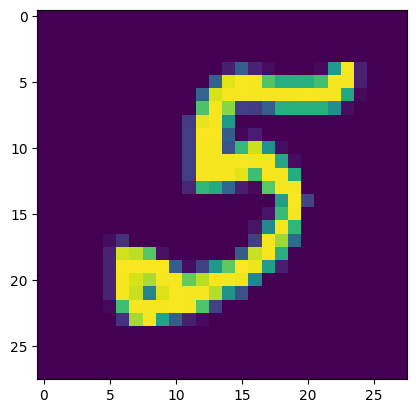

In [4]:
ind = 1
plt.imshow(train_images[ind])
print(f'Label: {train_labels[ind]}')
print(f'Image shape: {image_shape}')
print(f'Image middle row: {train_images[ind][image_side//2]}')

Перекодируем датасет в бинарные изображения и дальше будем работать с бинарными данными.

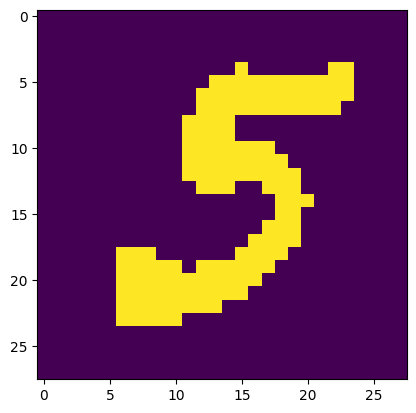

In [5]:
def plot_flatten_image(flatten_image, image_height=28):
    plt.imshow(flatten_image.reshape((image_height, -1)))

def to_binary_flatten_images(images):
    n_samples = images.shape[0]
    # flatten every image to vector
    images = images.reshape((n_samples, -1))
    # binary encoding: each image pixel is encoded either 0 or 1 depending on that image mean value
    images = (images >= images.mean(axis=1, keepdims=True)).astype(np.int8)
    return images


train_images = to_binary_flatten_images(train_images)
test_images = to_binary_flatten_images(test_images)
plot_flatten_image(train_images[ind])

## 02. Baseline: classifier on raw input

В качестве бейзлайна возьмем стандартный sklearn'овский логрег классификатор

In [6]:
LBFGS_MAX_ITER = 1_000

In [7]:
%%time

def test_bare_classification(x_tr,  y_tr, x_tst, y_tst):
    linreg = LogisticRegression(tol=.05, max_iter=LBFGS_MAX_ITER, multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=1)
    linreg.fit(x_tr, y_tr)

    score = linreg.predict(x_tst) == y_tst
    score = score.mean()
    print(f'Score: {100 * score:.1f}%')
    return score

np.random.seed(seed)
# for debug purposes I chose smaller subset of the train/test set, you can set the whole set of 60k training samples
n = 1_000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

# примерные/ориентировочные результаты
# 1k: 87.4; 888ms
# 60k: 91.4; 1.5min
_ = test_bare_classification(x_tr, y_tr, x_tst, y_tst)

Score: 87.4%
CPU times: user 1.94 s, sys: 602 ms, total: 2.54 s
Wall time: 1.76 s


## 03. Spatial Pooler: skeleton

Временно сделаем пустой класс Spatial Pooler'а заглушку, чтобы дальше ввести весь необходимый auxiliary код для обучения и тестирования.

In [8]:
class NoOpSpatialPooler:
    def __init__(self, input_size):
        self.input_size = input_size
        self.output_size = input_size

    def compute(self, dense_sdr, learn):
        # просто отдает вход на выход
        return np.flatnonzero(dense_sdr)


np.random.seed(seed)
sp = NoOpSpatialPooler(train_images[0].size)
sparse_sdr = sp.compute(train_images[0], True)

print(sparse_sdr.size, sp.output_size)
assert sparse_sdr.size < sp.output_size

91 784


## 04. Train/test SP performance aux pipeline

Ниже непосредственно код для обучения и тестирования классификации с использованием Spatial Pooler'а. Общая схема следующая - мы обучаем SP на train set'е, а дальше SDR векторы на выходе из SP используем в кач-ве входных данных для логрег классификатора в надежде, что эти данные разделимы еще лучше, то есть что качество классификации улучшится.

__NB__: Не удивляйся, в реализации ниже обучение идет в немного полуонлайн режиме - делается небольшой претрейн, а потом полностью онлайн. Претрейн делаем для прогрева SP, тк на ранних стадиях обучения он слишком сильно меняет выходную кодировку.

In [9]:
%%time

def pretrain_sp(sp, images, n_samples):

    for img in images[:n_samples]:
        sp.compute(img, True)

def encode_to_csr_with_sp(images, sp, learn):
    flatten_encoded_sdrs = []
    indptr = [0]
    for img in images:
        encoded_sparse_sdr = sp.compute(img, learn)
        flatten_encoded_sdrs.extend(encoded_sparse_sdr)
        indptr.append(len(flatten_encoded_sdrs))

    data = np.ones(len(flatten_encoded_sdrs))
    csr = csr_matrix((data, flatten_encoded_sdrs, indptr), shape=(images.shape[0], sp.output_size))
    return csr

def test_classification_with_sp(x_tr,  y_tr, x_tst, y_tst, sp):
    # a small pretrain SP before real work
    pretrain_sp(sp, x_tr, n_samples=1000)

    # encode images and continuously train SP
    csr = encode_to_csr_with_sp(x_tr, sp, learn=True)

    # train linreg
    linreg = LogisticRegression(tol=.05, max_iter=LBFGS_MAX_ITER, multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=3)
    linreg.fit(csr, y_tr)

    # encode test images (without SP learning) and then test score
    csr = encode_to_csr_with_sp(x_tst, sp, False)
    score = linreg.predict(csr) == y_tst
    score = score.mean()
    print(f'Score: {100 * score:.1f}% for n = {len(x_tr)}')
    return score

n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]
my_sp = NoOpSpatialPooler(train_images[0].size)

# 87.3; 1.16s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, my_sp)

Score: 87.4% for n = 1000
CPU times: user 150 ms, sys: 92.6 ms, total: 243 ms
Wall time: 1.98 s


0.874

## 05. Spatial Pooler: learning

__Здесь начинается практическое задание__

В этой части требуется реализовать простую версию SP с обучением как описано в видео htm scool до бустинга (т.е. бустинг пока не нужен).

In [10]:
import time

In [62]:
class LearnableSpatialPooler:
    def __init__(
        self, input_size, output_size, permanence_threshold, output_sparsity, synapse_permanence_deltas, receptive_field_sparsity
    ):
        '''
        params:
            `input_size` - the size of the input SDR
            `output_size` - the size of the output SDR
            `permanence_threshold` - value in [0, 1], defines whether or not a connection is active
            `output_sparsity` - value in [0, 1], defines desired output SDR sparsity, e.g. 0.02 is 2% sparsity
            `synapse_permanence_deltas` - tuple of (p+, p-), defines permanence increment/decrement for learning
            `receptive_field_sparsity` - value in [0, 1], defines the fraction of _potential_ synapses
        '''
        self.input_size = input_size
        self.output_size = output_size

        self.permanence_threshold = permanence_threshold
        self.output_sparsity = output_sparsity
        self.synapse_permanence_deltas = synapse_permanence_deltas
        self.receptive_field_sparsity = receptive_field_sparsity

        # 1 шаг : инициализация параметров SP
        self.n_active_bits =  int( output_sparsity *   output_size)
        self.num_synapse = int(self.receptive_field_sparsity* self.input_size)
        self.potential_synapse = np.zeros((self.output_size, self.num_synapse))
        self.permanence_value  = np.zeros((self.output_size, self.num_synapse))
        self.active_count = np.zeros(output_size)

        for c in range(0, self.output_size):
          self.potential_synapse[c] = np.random.choice(self.input_size, self.num_synapse, replace=False).astype(int)
          self.permanence_value[c] = np.random.uniform(0,1,self.num_synapse)
        self.potential_synapse = self.potential_synapse.astype(int)

    def get_active_count(self):
      return self.active_count

    def compute(self, dense_sdr, learn):
        '''
        params:
            `dense_sdr` - input SDR in dense for, i.e. as np.array
            `learn` - bool flag, whether or not to do a learning step

        returns:
            a list of activated columns indices
        '''

        # 2 шаг: подсчёт перекрытия для данной картинки дял каждой колонки

        overlap = np.zeros(self.output_size )
        overlap = np.sum((self.permanence_value> self. permanence_threshold)* dense_sdr[self.potential_synapse], axis=1)

        # 3 шаг: подсчёт самых активных колонок - победителей
        min_activity = np.sort(overlap)[::-1][int(self.output_sparsity*self.output_size)]
        active_col = np.where(overlap >  min_activity)[0].ravel()
        self.active_count[active_col] +=1


        # 4 шаг: обновление параметров синапсов и внутренних переменных
        if learn:
          for c in active_col:
            self.permanence_value[c] = np.where(self.permanence_value[c]  > self. permanence_threshold,self.permanence_value[c]  + self.synapse_permanence_deltas[0], self.permanence_value[c]  + (-1) * self.synapse_permanence_deltas[1])
            self.permanence_value[c]  = np.where(self.permanence_value[c]  > 1,1, self.permanence_value[c])
            self.permanence_value[c]  = np.where(self.permanence_value[c]  < 0,0, self.permanence_value[c])

        return np.array(active_col)


np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=10**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8
)
sparse_sdr = sp.compute(train_images[0], True)

print(sparse_sdr.size, sp.output_size, sp.n_active_bits)
assert sparse_sdr.size == sp.n_active_bits
sparse_sdr

4 100 4


array([ 3, 28, 64, 87])

### 05.1. Naive SP performance

Проверь качество работы своей реализации. В комментариях примерные значения для разных `n`, на которые можно попробовать ориентироваться:

In [ ]:
%%time

np.random.seed(seed)
n = 10
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8
)
# 1k: 80.2; 2.98s
# 60k: 89.3; 72 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 30.0% for n = 10
CPU times: user 199 ms, sys: 1.43 ms, total: 200 ms
Wall time: 883 ms


0.3

Score: 30.0% for n = 10

CPU times: user 32.2 s, sys: 130 ms, total: 32.3 s

Wall time: 33.5 s

0.3

In [ ]:
%%time

np.random.seed(seed)
n = 100
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8
)
# 1k: 80.2; 2.98s
# 60k: 89.3; 72 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 61.0% for n = 100
CPU times: user 848 ms, sys: 8.95 ms, total: 857 ms
Wall time: 910 ms


0.61

Score: 61.0% for n = 100

CPU times: user 5min 17s, sys: 718 ms, total: 5min 18s

Wall time: 5min 21s

0.61

In [ ]:
%%time

np.random.seed(seed)
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8
)
# 1k: 80.2; 2.98s
# 60k: 89.3; 72 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 77.1% for n = 1000
CPU times: user 8.41 s, sys: 22.1 ms, total: 8.43 s
Wall time: 8.66 s


0.771

Интересная метрика оценки качества работы SP и вырожденности датасета - энтропия выходных активаций.

Добавь либо в реализацию класса, либо где-то сбоку возможность учета статистики активаций выходных клеток (ты наверняка заметил, что обычно их контринтуитивно называют столбцами, что оч круто запутывает) и функцию подсчета энтропии на основе этой статистики. Собери такую статистику на одном прогоне на всем датасете и:

- нарисуй гистограмму частоты активаций (с нормализацией, чтобы по оси Y были вероятности активации, а не их число)
- посчитай энтропию $H = -\sum p \cdot \log p$

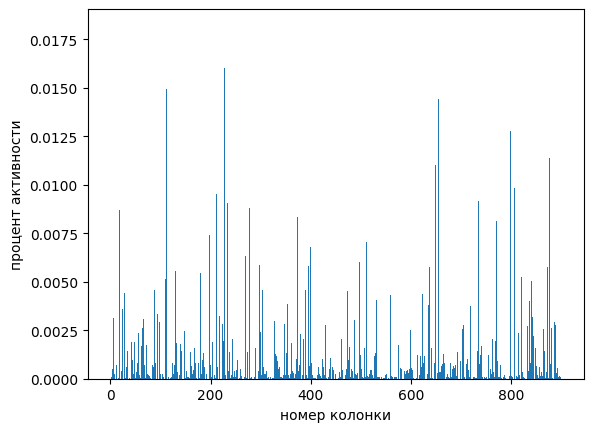

In [ ]:
active_count = sp.get_active_count()
p = active_count / np.sum (active_count)
plt.bar(np.arange(0, active_count.shape[0]),p, width=1)
plt.xlabel('номер колонки')
plt.ylabel('процент активности')
plt.show()

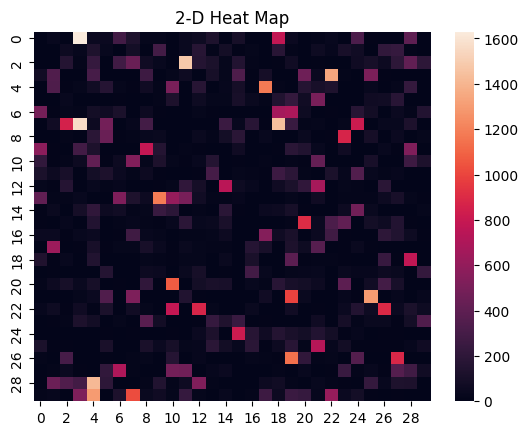

In [ ]:
import seaborn as sns
p_heat = p.reshape((int(np.sqrt(p.shape)),int(np.sqrt(p.shape)) ))
p_heat = p_heat.astype(float)
hm = sns.heatmap(data=p_heat)

plt.title( "2-D Heat Map" )
plt.show()

видим, что много малоактивных колонок.

In [ ]:
p1 = p[p>0]
entropy = - np.sum(np.log(p1)*p1)
entropy

5.599106803357271

Теперь давай посмотрим, как выходной размер `output_size` влияет на качество работы. Протестируй разные значения `output_size` - например, $[10^2, 15^2,..., 55^2, 60^2]$ и отрисуй график зависимости [качества классификации, но можешь и времени работы тоже].

_Можно для начала прикинуть для n=1000 и двигаться дальше, а позже пересчитать на всем датасете_

In [ ]:
output_size = (np.linspace(10, 60, num=11)**2).astype(int)
output_size

array([ 100,  225,  400,  625,  900, 1225, 1600, 2025, 2500, 3025, 3600])

In [ ]:
score = []
for i in output_size:
  sp = LearnableSpatialPooler(
      input_size=train_images[0].size,
      output_size=i,
      permanence_threshold=.5,
      output_sparsity=.04,
      synapse_permanence_deltas=(.1, .03),
      receptive_field_sparsity=.8
  )
  res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
  score.append(res)

Score: 49.7% for n = 1000
Score: 61.0% for n = 1000
Score: 69.7% for n = 1000
Score: 74.9% for n = 1000
Score: 80.6% for n = 1000
Score: 83.3% for n = 1000
Score: 83.4% for n = 1000
Score: 85.4% for n = 1000
Score: 86.2% for n = 1000
Score: 87.5% for n = 1000
Score: 86.8% for n = 1000


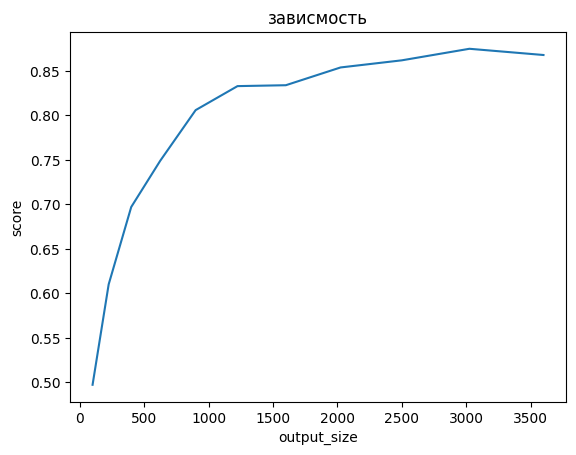

In [ ]:
plt.plot(output_size, score)
plt.xlabel('output_size')
plt.ylabel('score')
plt.title('зависмость')
plt.show()

зависимсоть прямая.

## 06. Spatial Pooler: boosting

В этом пункте требуется реализовать бустинг. Обрати внимание, в видео htm school речь ведется о бустинге overlap score на основе активности выходных ячеек -  именно такой вид бустинга и нужно реализовать. Еще есть бустинг значений permanence синапсов выходных ячеек, имеющих слишком низкое среднее значение overlap score за последние N итераций - рассмотрение этого вида бустинга оставим в стороне. Так что дальше под бустингом будет иметься в виду только первый вариант.

Зададим параметр `max_boost_factor` $\in [0, +\infty)$. Можно по-разному задавать интерпретацию этого параметра, то есть как будет действовать бустинг. Например, можно дать возможность бустингу работать только в сторону усиления слабых — тогда параметр `max_boost_factor` $=K$ определяет, что значения overlap score под действием бустинга могут быть увеличены максимум в $1+K$ раз. То есть `max_boost_factor`$=1$ означает, что оверлапы могут быть увеличены максимум в два раза, а 0 — что бустинг отключен.

Однако допустима и реализация, в которой бустинг работает в обе стороны — слабые колонки усиливает, а сильные наоборот ослабляет, и тогда пределы изменения для величины `max_boost_factor` $=K$: $[\frac{1}{K}, K]$, то есть бустинг может и усилить, и ослабить максимум в $K$ раз. В своей реализации выбери любой из этих вариантов.

In [42]:
from collections import deque
import time

In [43]:
class BoostedSpatialPooler:
    def __init__(
        self, input_size, output_size, permanence_threshold, output_sparsity, synapse_permanence_deltas, receptive_field_sparsity,
        max_boost_factor, boost_sliding_window
    ):
        '''
        params:
            `input_size` - the size of the input SDR
            `output_size` - the size of the output SDR
            `permanence_threshold` - value in [0, 1], defines whether or not a connection is active
            `output_sparsity` - value in [0, 1], defines desired output SDR sparsity, e.g. 0.02 is 2% sparsity
            `synapse_permanence_deltas` - tuple of (p+, p-), defines permanence increment/decrement for learning
            `receptive_field_sparsity` - value in [0, 1], defines the fraction of _potential_ synapses
            `max_boost_factor` - value in [0, +inf), defines maximum allowed boosting. Boosting value X > 0 (X < 0) means that overlap is multiplied (divided) by `1 + X`.
            `boost_sliding_window` - value in [1, +inf), defines the size of the window for moving avg output column activity
        '''
        self.input_size = input_size
        self.output_size = output_size
        self.permanence_threshold = permanence_threshold
        self.output_sparsity = output_sparsity
        self.synapse_permanence_deltas = synapse_permanence_deltas
        self.receptive_field_sparsity = receptive_field_sparsity
        self. boost_sliding_window  = boost_sliding_window
        self.max_boost_factor = max_boost_factor

        # 1 шаг : инициализация параметров SP

        self.n_active_bits =  int( output_sparsity *   output_size)
        self.num_synapse = int(self.receptive_field_sparsity* self.input_size)
        self.potential_synapse = np.zeros((self.output_size, self.num_synapse))
        self.permanence_value  = np.zeros((self.output_size, self.num_synapse))
        self.active_count = np.zeros(output_size)
        self.boost = np.ones(output_size)
        self.summa = np.ones(output_size)
        self.num = 0
        self.q = []
        for i in range(0, output_size):
          self.q.append([])
        for c in range(0, self.output_size):
          self.potential_synapse[c] = np.random.choice(self.input_size, self.num_synapse, replace=False)
          self.permanence_value[c] = np.random.uniform(0,1,self.num_synapse)
        self.potential_synapse = self.potential_synapse.astype(int)
        self.times = [0,0,0]

    def get_times(self):
      return self.times

    def get_active_count(self):
      return self.active_count

    def compute(self, dense_sdr, learn):
        '''
        params:
            `dense_sdr` - input SDR in dense for, i.e. as np.array
            `learn` - bool flag, whether or not to do a learning step

        returns:
            a list of activated columns indices
        '''
        start = time.time()
        # 2 шаг: подсчёт перекрытия для данной картинки дял каждой колонки
        overlap = np.zeros(self.output_size )
        boost_list = np.array(list(self.boost) * self.permanence_value.shape[1]).reshape((self.permanence_value.shape[1], self.permanence_value.shape[0])).T
        overlap = np.sum((self.permanence_value> self. permanence_threshold)* dense_sdr[self.potential_synapse]*boost_list, axis=1)
        end = time.time()

        self.times[0]+= (end-start)
        start = time.time()

        # 3 шаг: подсчёт самых активных колонок - победителей
        min_activity = np.sort(overlap)[::-1][int(self.output_sparsity*self.output_size)]
        add = (overlap >  min_activity).astype(int)
        active_col = np.where(add)[0].ravel()
        self.active_count[active_col] +=1
        for c in range(0, self.output_size):
          if overlap[c] >  min_activity:
            self.summa[c] += 1
            if len( self.q[c] ) < self.boost_sliding_window:
              self.q[c].append(1)
            else:
              self.summa[c]  -= self.q[c].pop()
              self.q[c].append(1)

          else:
            self.summa[c] += 0

            if len(self.q[c]) < self.boost_sliding_window:
              self.q[c].append(0)
            else:
              self.summa[c] -= self.q[c].pop()
              self.q[c].append(0)

        end = time.time()
        self.times[1]+= (end-start)
        start = time.time()
        # 4 шаг: обновление параметров синапсов и внутренних переменных
        if learn:
          for c in active_col:
            self.permanence_value[c] = np.where(self.permanence_value[c]  > self. permanence_threshold,self.permanence_value[c]  + self.synapse_permanence_deltas[0], self.permanence_value[c]  + (-1) * self.synapse_permanence_deltas[1])
            self.permanence_value[c]  = np.where(self.permanence_value[c]  > 1,1, self.permanence_value[c])
            self.permanence_value[c]  = np.where(self.permanence_value[c]  < 0,0, self.permanence_value[c])

          boost_max = np.exp((self.summa.max()-self.summa.mean())/(self.boost_sliding_window)*(-1))

          self.boost = np.exp((self.summa-self.summa.mean())/(self.boost_sliding_window)*(-1))/ boost_max * (self.max_boost_factor+1)

        end = time.time()
        self.times[2]+= (end-start)

        return np.array(active_col)


np.random.seed(seed)
my_sp = BoostedSpatialPooler(
    train_images[0].size, output_size=10**2, permanence_threshold=.5, output_sparsity=.04, synapse_permanence_deltas=(.1, .02),
    receptive_field_sparsity=.8, max_boost_factor=0.5, boost_sliding_window=1000
)
my_sp.compute(train_images[0], True)

array([ 3, 28, 64, 87])

### 06.1. SP with boosting performance

_Дальше все как и в пункте 05.1_

Проверь качество работы своей реализации. В комментариях по-прежнему примерные значения для разных `n`, на которые можно попробовать ориентироваться:

In [46]:
%%time

np.random.seed(seed)
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 1k: 84.0; 3.24 s
# 60k: 91.15; 86 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 84.2% for n = 1000
CPU times: user 2min 13s, sys: 326 ms, total: 2min 13s
Wall time: 2min 16s


0.842

In [47]:
times = np.array(sp.get_times())
procent = times / np.sum(times)
print(procent)

[0.94496852 0.03038788 0.0246436 ]


- нарисуй гистограмму вероятностей активаций
- посчитай энтропию $H = -\sum p \cdot \log p$
- сравни с результатами без бустинга - есть какие-то очевидные выводы?

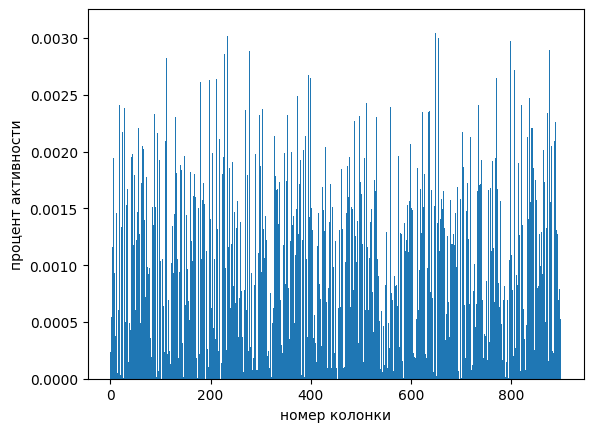

In [ ]:
active_count = sp.get_active_count()
p = active_count/np.sum(active_count)
plt.bar(np.arange(0, active_count.shape[0]), p, width = 1)
plt.xlabel('номер колонки')
plt.ylabel('процент активности')
plt.show()

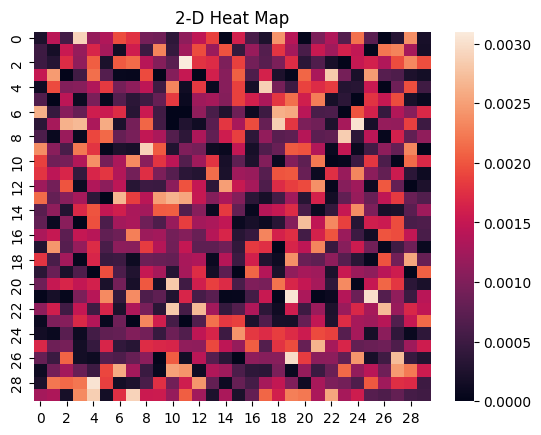

In [ ]:
import seaborn as sns
p_heat = p.reshape((int(np.sqrt(p.shape)),int(np.sqrt(p.shape)) ))
p_heat = p_heat.astype(float)
hm = sns.heatmap(data=p_heat)

plt.title( "2-D Heat Map" )
plt.show()

In [ ]:
p1 = p[p>0]
entropy = - np.sum(np.log(p1)*p1)
entropy

6.555286897434601

энтропия увеличилась. Также по графикам можно сказать, что количество малоактивных колонок уменьшилось, и каждая из колонок получила свою *область воздействия*, свой шаблон, что увеличило производительность и скор.

Протестируй разные значения `output_size` - например, $[10^2, 15^2,..., 55^2, 60^2]$ и отрисуй график зависимости [качества классификации, но можешь и времени работы тоже].

Сравни с результатами без бустинга

In [ ]:
output_size = (np.linspace(10, 60, num=11)**2).astype(int)
output_size

array([ 100,  225,  400,  625,  900, 1225, 1600, 2025, 2500, 3025, 3600])

In [ ]:
score = []
for i in output_size:
  sp = BoostedSpatialPooler(
      input_size=train_images[0].size,
      output_size = i,
      permanence_threshold=.5,
      output_sparsity=.04,
      synapse_permanence_deltas=(.1, .03),
      receptive_field_sparsity=.8,
      max_boost_factor=2,
      boost_sliding_window=1000
  )
  res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
  score.append(res)

Score: 54.0% for n = 1000
Score: 69.6% for n = 1000
Score: 76.2% for n = 1000
Score: 82.4% for n = 1000
Score: 82.6% for n = 1000
Score: 86.1% for n = 1000
Score: 87.1% for n = 1000
Score: 89.0% for n = 1000
Score: 88.3% for n = 1000
Score: 88.4% for n = 1000
Score: 89.4% for n = 1000


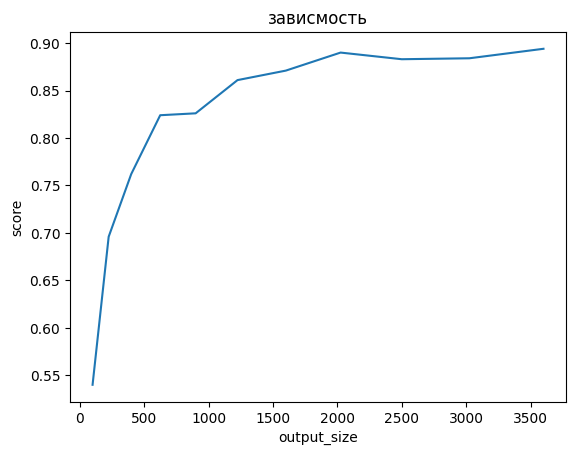

In [ ]:
plt.plot(output_size, score)
plt.xlabel('output_size')
plt.ylabel('score')
plt.title('зависмость')
plt.show()

график более крутой. но в целом тенденция аналогичная - зависимость прямая.

___
__[Опционально]__ можешь ради интереса поиграться с таким параметром как `receptive_field_sparsity`. Возьми в качестве выходного размера `output_size` = $50^2$ и проверь результаты на разных значениях параметра $[0.4, 0.5, ..., 1.0]$ и построй график зависимости.

сделано ниже

In [63]:
%%time
n = 1000
receptive_field_sparsity = [0.4,0.5,0.6,0.7,0.8,0.9,1]
score = []
for  i in receptive_field_sparsity:
  x_tr, y_tr = train_images[:n], train_labels[:n]
  x_tst, y_tst = test_images[:n], test_labels[:n]
  np.random.seed(seed)
  sp = LearnableSpatialPooler(
      input_size=train_images[0].size,
      output_size=50**2,
      permanence_threshold=.5,
      output_sparsity=.04,
      synapse_permanence_deltas=(.1, .03),
      receptive_field_sparsity=i,
  )

  score.append(test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp))

Score: 86.5% for n = 1000
Score: 86.6% for n = 1000
Score: 87.0% for n = 1000
Score: 87.7% for n = 1000
Score: 85.7% for n = 1000
Score: 85.9% for n = 1000
Score: 88.0% for n = 1000
CPU times: user 2min 31s, sys: 484 ms, total: 2min 31s
Wall time: 2min 38s


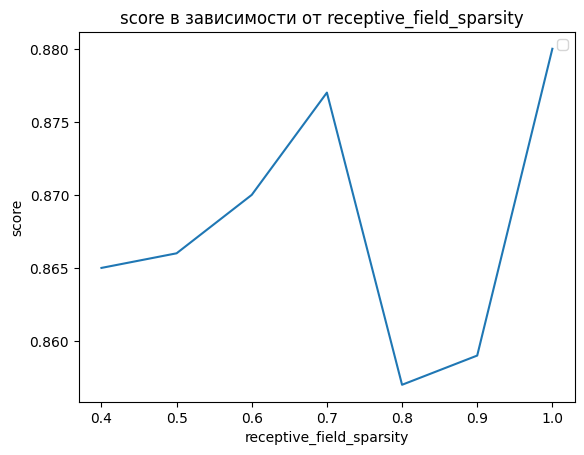

In [64]:
plt.plot(receptive_field_sparsity, score)
plt.xlabel('receptive_field_sparsity')
plt.ylabel('score')
plt.legend()
plt.title('score в зависимости от receptive_field_sparsity  ')
plt.show()

монотонной зависимости не видим.

## 07. TESTING

Дальше просто сравнительное тестирование получившихся результатов.

In [67]:
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

In [ ]:
%%time

def test_bare_classification(x_tr,  y_tr, x_tst, y_tst):
    linreg = LogisticRegression(tol=.05, max_iter=LBFGS_MAX_ITER, multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=3)
    linreg.fit(x_tr, y_tr)

    score = linreg.predict(x_tst) == y_tst
    score = score.mean()
    print(f'Score: {100 * score:.1f}%')
    return score

np.random.seed(seed)
# 92.11; 38s
test_bare_classification(x_tr, y_tr, x_tst, y_tst)

Score: 91.4%
CPU times: user 4.36 s, sys: 1.47 s, total: 5.84 s
Wall time: 5min 3s


0.9143

In [ ]:
%%time

np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
)
# 89.3; 72 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 87.7% for n = 60000
CPU times: user 4min 2s, sys: 669 ms, total: 4min 2s
Wall time: 4min 32s


0.8771

In [ ]:
%%time

np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=50**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
)
# 93.15; 221 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 92.5% for n = 60000
CPU times: user 11min 1s, sys: 1.71 s, total: 11min 2s
Wall time: 11min 57s


0.9249

я взяла  n = 1000 вместо n = 60000

In [68]:
%%time
np.random.seed(seed)
sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 91.15; 86 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 84.2% for n = 1000
CPU times: user 2min 17s, sys: 594 ms, total: 2min 17s
Wall time: 2min 21s


0.842

In [69]:
%%time

np.random.seed(seed)
sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=50**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 94.44; 238 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 89.8% for n = 1000
CPU times: user 6min 14s, sys: 991 ms, total: 6min 15s
Wall time: 6min 22s


0.898

## Improve SP implementation

Теперь, когда у тебя есть готовая реализация SpatialPooler, время для улучшения/ускорения реализации. Попробуй выполнить задания ниже.

1. **Векторизация**: нужна векторизованная реализация, которая будет эффективно вычислять overlap score, boosting и все остальное. Важно ответить себе на вопрос, как организовать хранение рецептивных полей нейронов SP, как делать pattern matching для входного паттерна, как эффективно делать шаг обновления. Придется поиграться с разными реализациями, измеряя скорость их работы. Ну и вообще, сейчас самое время причесать свою реализациюи довести ее до финального вида.

2. **Разреженные рецептивные поля**: можно ли улучшить качество работы SP, если уменьшить размеры рецептивных полей его нейронов (но возможно увеличив количество нейронов)? Зафиксируй какое-нибудь определенный лимит времени работы SP и попробуй варьировать эти два гиперпараметра (`receptive_field_sparsity` и `output_size`), чтобы оставаться в рамках лимита. Нарисуй график зависимости качества от этих двух параметров.

3. [**СЛОЖНО**] **Newborn-stage**: В [On the importance of the newborn stage when learning patterns with the Spatial Pooler](https://link.springer.com/article/10.1007/s42979-022-01066-4) описана идея, что бустинг, вообще говоря, имеет и негативную сторону — он имеет смысл лишь на ранних стадиях формирования рецептивных полей нейронов. Но далее он только влечет к нестабильности (способствует дрифту кодировки на выходе из SP за счет переучивания его нейронов). Предлагается взять эту идею (статью подробно читать для этого не нужно) и добавить newborn stage в SP. Для этого сделай отдельную реализацию, чтобы у тебя была отдельная финальная версия без этой фичи, и отдельная уже с. Newborn stage будет разделен на K этапов, в процессе которых
    1. Бустинг будет постепенно снижаться (например, линейно) к нулю
    2. Рецептивные поля будут уменьшаться. Таким образом SP будет инициализироваться с большими рецептивными полями, но в процессе newborn stage они будут постепенно пруниться до целевых значений. Это позволит нам во взрослой стадии иметь быстрый (за счет маленьких рецептивных полей) SP с хорошо настроенными рецептивными полями, из-за чего качество будет не сильно хуже, чем если бы мы не прунили.
   
   Протестируй данную реализацию с разными настройками начального и конечного размера рецептивных полей.

### 1

1 способ : накопительная сумма

In [ ]:
# 3 шаг: подсчёт самых активных колонок - победителей
min_activity = np.sort(overlap)[::-1][int(self.output_sparsity*self.output_size)]
active_col = np.where(overlap >  min_activity)[0].ravel()
self.active_count[active_col] +=1
all_sum  = self.summa *  self.num
self.num = min( self.num+1, self.boost_sliding_window)
add = (overlap >  min_activity)
cur_sum = (all_sum + add) /  self.num
self.summa += (cur_sum - self.summa) * (0.01)


In [ ]:
%%time

np.random.seed(seed)
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 1k: 84.0; 3.24 s
# 60k: 91.15; 86 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 78.9% for n = 1000
CPU times: user 2min 6s, sys: 369 ms, total: 2min 6s
Wall time: 2min 7s


0.789

как можно заметить, качество значительно снизилось, при этом скорость не увеличилась. СТоит отбросить этот способ и оставить sliding window .

2 способ : попытка векторизации sliding window

In [ ]:
# 3 шаг: подсчёт самых активных колонок - победителей
min_activity = np.sort(overlap)[::-1][int(self.output_sparsity*self.output_size)]
add = (overlap >  min_activity).astype(int)
active_col = np.where(add)[0].ravel()
self.active_count[active_col] +=1
if  self.q.shape[0] == 0:
  self.q = add.reshape((add.shape[0],-1))
else:
  self.q = np.column_stack((self.q, add))
self.summa += add
if self.q.shape[1] >= self.boost_sliding_window:
  self.summa -= self.q[:,0]
  self.q = np.delete(self.q, 0, axis = 1)






In [ ]:
%%time

np.random.seed(seed)
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 1k: 84.0; 3.24 s
# 60k: 91.15; 86 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 82.8% for n = 1000
CPU times: user 2min 13s, sys: 350 ms, total: 2min 13s
Wall time: 2min 15s


0.828

как мы видим, качество оказалось чуть ниже референсного, при этом скорость не увеличилась - оставила референсное.

При необходимость можно попробовать привести к вектоному виду, но это не должно добавить существенного прибавления к скорости.

Для наглядности засечем время работы программы на каждом из шагов:

In [ ]:
%%time

np.random.seed(seed)
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 1k: 84.0; 3.24 s
# 60k: 91.15; 86 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 84.2% for n = 1000
CPU times: user 2min 13s, sys: 326 ms, total: 2min 13s
Wall time: 2min 16s


0.842

In [ ]:
times = np.array(sp.get_times())
procent = times / np.sum(times)
print(procent)

[0.94496852 0.03038788 0.0246436 ]


почти весь объем времени затрачивается на втором шаге.

(# 2 шаг: подсчёт перекрытия для данной картинки для каждой колонки)

он итак векторизован. Еще больше можно увеличить скорость работы, распераллелив процессы, ведь колонки независимы друг от друга.

оптимизировать 3 и 4 шаг не имеет большого смысла.

  ***

In [49]:
train_images[0].size

784

Еще можно было бы поиграть с формой рецептивных полей и сделать их аналогично свертки из статьи на гитхабе.

То есть, рецептивное поле для каждой из колонки - квадрат, и каждая активная колонка гасит другие колонки в пределах своего радиуса. Получается, соревнуются за право быть активными те колонки, которые делят между собой одно поле нейронов, что имеет отражение в биологии : можно сказать, что в таком случае каждая колонка отображает разные реакции на один и тот же раздражитель, который как раз и определяется общим полем нейронов.

в нашем случае колонок больше, чем нейронов, и не совсем понятно, как в таком случае писать свертку.  (train_images[0].size = 784 против 900 колонок)
Кажется, что наоборот - колонок должно быть меньше, чем нейронов.
Возможно, стоит поставить ограничение на то, что колонок строго меньше в n число раз, чем нейронов, и уже с таким условием писать свёртку.

#2

точек не так много, то что вместо random grid можно просто пройтись по двумерной сетке.

In [281]:
receptive_field_sparsity = (np.linspace(0.4, 1, num=10))
output_size = (np.linspace(40, 60, num=5)**2).astype(int)
output_size
n = 300
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

score = []
for i in range(0, len(output_size)):
  score.append([])
print(score)
cnt=-1
for i in output_size:
  cnt+=1

  for j in receptive_field_sparsity:
    sp = BoostedSpatialPooler(
        input_size=train_images[0].size,
        output_size = i,
        permanence_threshold=.5,
        output_sparsity=.04,
        synapse_permanence_deltas=(.1, .03),
        receptive_field_sparsity=j,
        max_boost_factor=2,
        boost_sliding_window=1000
    )
    res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
    score[cnt].append(res)

[[], [], [], [], []]
Score: 83.0% for n = 300
Score: 83.7% for n = 300
Score: 84.0% for n = 300
Score: 80.0% for n = 300
Score: 83.0% for n = 300
Score: 81.3% for n = 300
Score: 83.3% for n = 300
Score: 83.7% for n = 300
Score: 80.3% for n = 300
Score: 80.0% for n = 300
Score: 85.0% for n = 300
Score: 83.7% for n = 300
Score: 85.0% for n = 300
Score: 84.7% for n = 300
Score: 85.3% for n = 300
Score: 84.3% for n = 300
Score: 87.3% for n = 300
Score: 84.0% for n = 300
Score: 88.3% for n = 300
Score: 83.7% for n = 300
Score: 88.0% for n = 300
Score: 84.3% for n = 300
Score: 86.0% for n = 300
Score: 85.3% for n = 300
Score: 85.3% for n = 300
Score: 86.7% for n = 300
Score: 84.7% for n = 300
Score: 86.7% for n = 300
Score: 88.0% for n = 300
Score: 84.7% for n = 300
Score: 88.0% for n = 300
Score: 83.3% for n = 300
Score: 88.7% for n = 300
Score: 85.0% for n = 300
Score: 86.3% for n = 300
Score: 86.0% for n = 300
Score: 88.0% for n = 300
Score: 85.7% for n = 300
Score: 87.0% for n = 300
Scor

In [ ]:
import pandas as pd
field = [round(i, 2) for   j in range (0,output_size.shape[0]) for i in receptive_field_sparsity]
output =  [i for i in output_size for j in range (0,receptive_field_sparsity.shape[0])]
print(len(field))
print(len(output))
print(len(score))
df = pd.DataFrame(data ={'receptive_field_sparsity':field, 'output_size':output, 'score':np.array(score).ravel()})
df


In [24]:
df['prod'] = df['receptive_field_sparsity'] * df['output_size']
df.sort_values(by=['score'], ascending = False)[:20]

,receptive_field_sparsity,output_size,score,prod
46,0.80,3600,89.3,2880.00
48,0.93,3600,89.0,3348.00
32,0.53,3025,88.7,1603.25
49,1.00,3600,88.3,3600.00
18,0.93,2025,88.3,1883.25
44,0.67,3600,88.3,2412.00
28,0.93,2500,88.0,2325.00
30,0.40,3025,88.0,1210.00
36,0.80,3025,88.0,2420.00
20,0.40,2500,88.0,1000.00


<ipython-input-27-036b505d1418>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  new_df = df.pivot('receptive_field_sparsity', 'output_size', 'score')


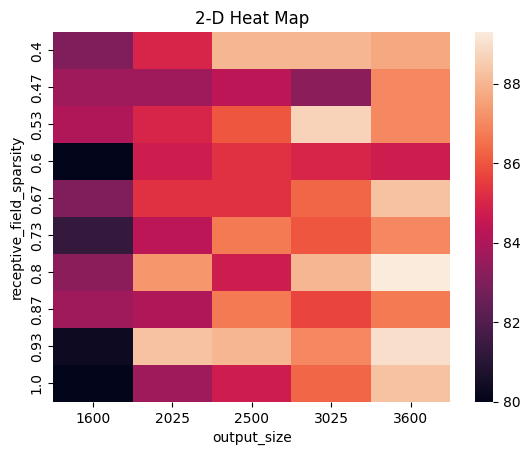

In [27]:
new_df = df.pivot('receptive_field_sparsity', 'output_size', 'score')
hm = sns.heatmap(data=new_df)

plt.title( "2-D Heat Map" )

plt.show()

видим, что с увеличением output_size в среднем увеличивается  score.

Про receptive_field_sparsity нельзя такого сказать.

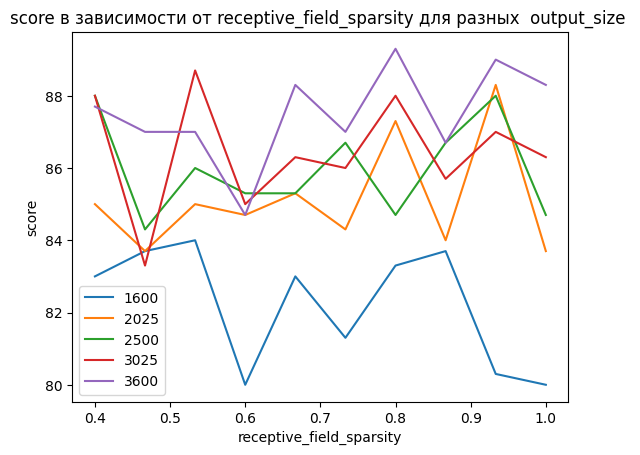

In [37]:
for score_i, output_size_i in zip(score_r,output_size):
  plt.plot(receptive_field_sparsity, score_i, label = (str(output_size_i)))
  plt.xlabel('receptive_field_sparsity')
  plt.ylabel('score')
plt.legend()
plt.title('score в зависимости от receptive_field_sparsity для разных  output_size ')
plt.show()

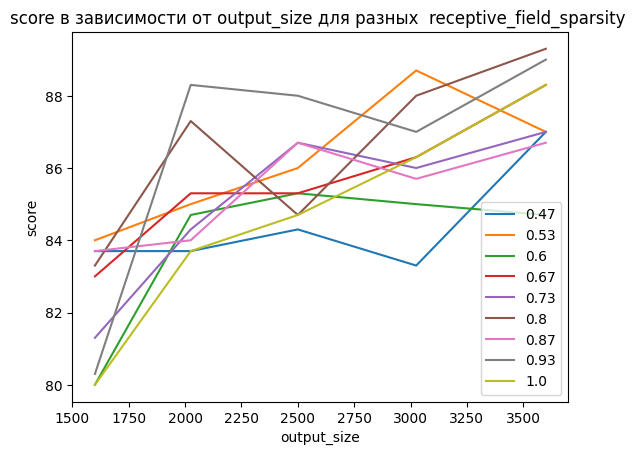

In [40]:
receptive_field_sparsity_round = [round(i, 2) for i in receptive_field_sparsity]
for score_i, receptive_field_sparsity_i in zip(score_r.T[1:], receptive_field_sparsity_round[1:]):
  plt.plot(output_size, score_i, label = (str(receptive_field_sparsity_i)))
  plt.xlabel('output_size')
  plt.ylabel('score')
plt.legend()
plt.title('score в зависимости от output_size для разных  receptive_field_sparsity ')
plt.show()

можно сказать, что score увеличивается при увеличении output_size

In [53]:
receptive_field_sparsity = (np.linspace(0.02, 0.2, num=10))
output_size = [3000]
n = 300
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

score = []
for i in range(0, len(output_size)):
  score.append([])
print(score)
cnt=-1
for i in output_size:
  cnt+=1

  for j in receptive_field_sparsity:
    sp = BoostedSpatialPooler(
        input_size=train_images[0].size,
        output_size = i,
        permanence_threshold=.5,
        output_sparsity=.04,
        synapse_permanence_deltas=(.1, .03),
        receptive_field_sparsity=j,
        max_boost_factor=2,
        boost_sliding_window=1000
    )
    res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
    score[cnt].append(res)

[[]]
Score: 85.3% for n = 300
Score: 83.7% for n = 300
Score: 86.3% for n = 300
Score: 85.7% for n = 300
Score: 85.7% for n = 300
Score: 84.3% for n = 300
Score: 86.7% for n = 300
Score: 86.3% for n = 300
Score: 85.3% for n = 300
Score: 83.7% for n = 300


прямой зависимости score от receptive_field_sparsity не прослеживается при достаточно больших receptive_field_sparsity

посмотрим еще на графики при других вводных данных, n = 100

<ipython-input-230-6bf11fc97b94>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  new_df = df.pivot('receptive_field_sparsity', 'output_size', 'score')


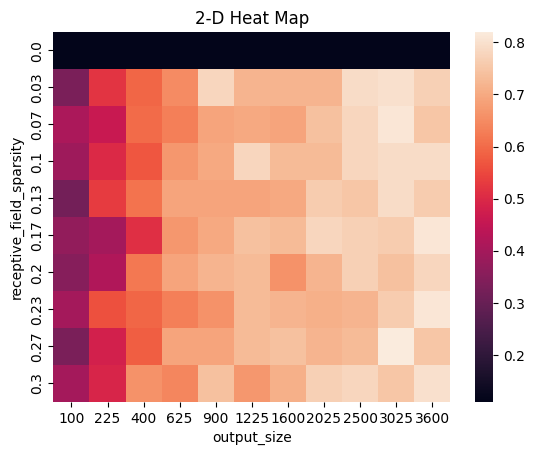

In [ ]:
new_df = df.pivot('receptive_field_sparsity', 'output_size', 'score')
hm = sns.heatmap(data=new_df)

plt.title( "2-D Heat Map" )

plt.show()

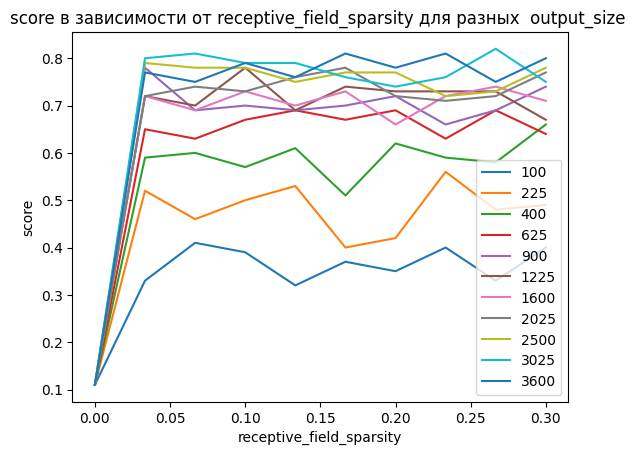

In [ ]:
for score_i, output_size_i in zip(score,output_size):
  plt.plot(receptive_field_sparsity, score_i, label = (str(output_size_i)))
  plt.xlabel('receptive_field_sparsity')
  plt.ylabel('score')
plt.legend()
plt.title('score в зависимости от receptive_field_sparsity для разных  output_size ')
plt.show()

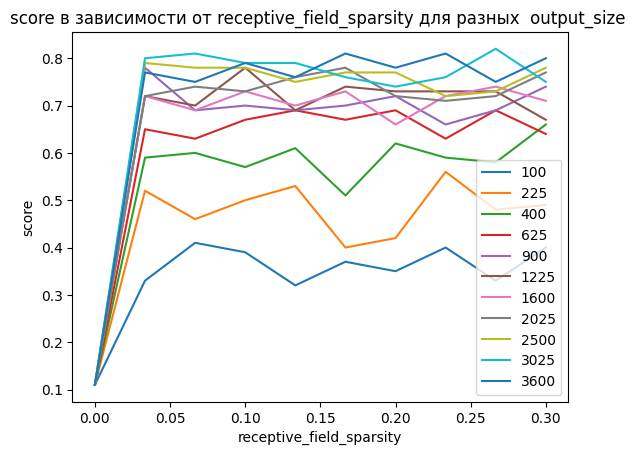

In [ ]:
for score_i, output_size_i in zip(score,output_size):
  plt.plot(receptive_field_sparsity, score_i, label = (str(output_size_i)))
  plt.xlabel('receptive_field_sparsity')
  plt.ylabel('score')
plt.legend()
plt.title('score в зависимости от receptive_field_sparsity для разных  output_size ')
plt.show()

In [ ]:
df['prod'] = df['receptive_field_sparsity'] * df['output_size']
df.sort_values(by=['score'], ascending = False)[:20]

,receptive_field_sparsity,output_size,score,prod
98,0.27,3025,0.82,816.75
107,0.23,3600,0.81,828.00
105,0.17,3600,0.81,612.00
92,0.07,3025,0.81,211.75
109,0.30,3600,0.80,1080.00
91,0.03,3025,0.80,90.75
81,0.03,2500,0.79,75.00
94,0.13,3025,0.79,393.25
93,0.10,3025,0.79,302.50
103,0.10,3600,0.79,360.00


ситуация аналогична.

Таким образом, можно утверждать, что

1)прямой зависимости score от receptive_field_sparsity не прослеживается при достаточно больших receptive_field_sparsity

2)с увеличением output_size в среднем увеличивается score


С увеличением колонок и правда логично ожидать увеличения score - ведь можно зафиксировать больше паттернов, шаблонов, на которые мы сможем разбивать картинки.

С увеличением receptive_field_sparsity увеличивается количество потенциальных связей, но не из количество, так как активность должна перевалить за permanence_threshold .

Можно утверждать, чтоreceptive_field_sparsity будет негативно сказываться на качестве работы в том случае, если оно будет настолько мало, что плотности будет недостаточно для того, чтобы нужное число импульсов перевалило за permanence_threshold.




In [57]:
receptive_field_sparsity = (np.linspace(0.00, 0.06, num=40))
output_size = [300]
n = 300
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

score = []
for i in range(0, len(output_size)):
  score.append([])
print(score)
cnt=-1
for i in output_size:
  cnt+=1

  for j in receptive_field_sparsity:
    sp = BoostedSpatialPooler(
        input_size=train_images[0].size,
        output_size = i,
        permanence_threshold=.5,
        output_sparsity=.04,
        synapse_permanence_deltas=(.1, .03),
        receptive_field_sparsity=j,
        max_boost_factor=2,
        boost_sliding_window=1000
    )
    res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

[[]]
Score: 10.0% for n = 300
Score: 13.7% for n = 300
Score: 59.0% for n = 300
Score: 59.7% for n = 300
Score: 65.3% for n = 300
Score: 71.0% for n = 300
Score: 65.3% for n = 300
Score: 66.7% for n = 300
Score: 66.3% for n = 300
Score: 64.7% for n = 300
Score: 66.3% for n = 300
Score: 68.7% for n = 300
Score: 64.3% for n = 300
Score: 68.3% for n = 300
Score: 67.3% for n = 300
Score: 61.7% for n = 300
Score: 64.7% for n = 300
Score: 65.7% for n = 300
Score: 66.3% for n = 300
Score: 65.0% for n = 300
Score: 64.3% for n = 300
Score: 65.0% for n = 300
Score: 65.0% for n = 300
Score: 62.7% for n = 300
Score: 65.0% for n = 300
Score: 64.3% for n = 300
Score: 61.3% for n = 300
Score: 66.0% for n = 300
Score: 64.3% for n = 300
Score: 66.3% for n = 300
Score: 66.0% for n = 300
Score: 69.3% for n = 300
Score: 61.3% for n = 300
Score: 62.0% for n = 300
Score: 63.0% for n = 300
Score: 61.7% for n = 300
Score: 65.7% for n = 300
Score: 65.3% for n = 300
Score: 64.7% for n = 300
Score: 63.0% for n =

Как мы видим, это наблюдаеися при очень маленькой плотности.  С её ростом ситуация становится лучше.

In [54]:
receptive_field_sparsity = (np.linspace(0.00, 0.02, num=10))
output_size = [3000]
n = 300
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

score = []
for i in range(0, len(output_size)):
  score.append([])
print(score)
cnt=-1
for i in output_size:
  cnt+=1

  for j in receptive_field_sparsity:
    sp = BoostedSpatialPooler(
        input_size=train_images[0].size,
        output_size = i,
        permanence_threshold=.5,
        output_sparsity=.04,
        synapse_permanence_deltas=(.1, .03),
        receptive_field_sparsity=j,
        max_boost_factor=2,
        boost_sliding_window=1000
    )
    res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
    score[cnt].append(res)

[[]]
Score: 10.0% for n = 300
Score: 46.0% for n = 300
Score: 85.0% for n = 300
Score: 86.3% for n = 300
Score: 83.7% for n = 300
Score: 84.7% for n = 300
Score: 86.7% for n = 300
Score: 85.3% for n = 300
Score: 84.3% for n = 300
Score: 85.0% for n = 300


Но ситуацию можно исправить даже при маленькой плотности, если увеличить число колонок.

In [ ]:
receptive_field_sparsity = (np.linspace(0.7, 0.9, num=40))
output_size = [300]
n = 300
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

score = []
for i in range(0, len(output_size)):
  score.append([])
print(score)
cnt=-1
for i in output_size:
  cnt+=1

  for j in receptive_field_sparsity:
    sp = BoostedSpatialPooler(
        input_size=train_images[0].size,
        output_size = i,
        permanence_threshold=.5,
        output_sparsity=.04,
        synapse_permanence_deltas=(.1, .03),
        receptive_field_sparsity=j,
        max_boost_factor=2,
        boost_sliding_window=1000
    )
    res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 62.3% for n = 300

Score: 62.7% for n = 300

Score: 63.7% for n = 300

Score: 62.7% for n = 300

Score: 63.3% for n = 300

Score: 62.0% for n = 300

как можно увидеть, слишком большая плотность - тоже плохо, ведь тогда по сути внимание колонок распыляется, и они становятся не такими высокодифференцированными.

Таким образом,

1) с увеличением output_size в среднем увеличивается score

2) receptive_field_sparsity не должен быть слишком большим или малым. Точные границы свои для каждого output_size .

3) можно  улучшить качество работы SP, если уменьшить размеры рецептивных полей его нейронов, но при этом стоит увеличить количество нейронов. Иногда можно обойтись и без увеличения, если размер рецептивных полей изначально слишком большой.